# Modified MNIST classification challenge - DenseNet

Instead of building our own model from scratch, we will use a state-of-the-art model to approach the challenge. 

In [1]:

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

keras = tf.keras


import os
import cv2
import time
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline


from glob import glob
from PIL import Image
from tqdm import tqdm_notebook
from IPython.display import Image
from sklearn.datasets import load_files   
from sklearn.model_selection import train_test_split 
from urllib.request import urlopen,urlretrieve


from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import load_model

from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)) 


TensorFlow 2.x selected.


Using TensorFlow backend.


True
True


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 2. Loading and pre-processing the dataset 

We will first load and take a look ad the dataset, then apply some preprocessing. 

### 2.1 Load the data

In [3]:
## Read train and test images. NOTE: This is a bit slow.
t0 = time.time()
train_images = pd.read_pickle('./drive/My Drive/train_max_x') 
test_images = pd.read_pickle('./drive/My Drive/test_max_x')
train_labels = pd.read_csv("./drive/My Drive/train_max_y.csv").iloc[:,1]
LABELS= sorted(set(train_labels))
t1 = time.time()
print("Done in {} seconds".format(t1-t0))

# print(os.getcwd())
# files = [f for f in os.listdir('.') if os.path.isfile(f)]
# print(files)

Done in 53.049211502075195 seconds


In [4]:
print(train_labels.head(10))

0    6
1    7
2    2
3    9
4    7
5    8
6    7
7    6
8    8
9    8
Name: Label, dtype: int64


We can now see a couple of samples along with their tags

Label: 6
Label: 7
Label: 2
Label: 9


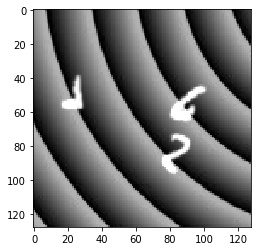

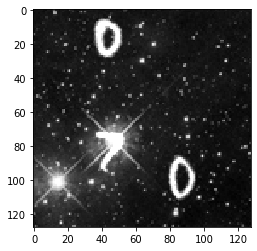

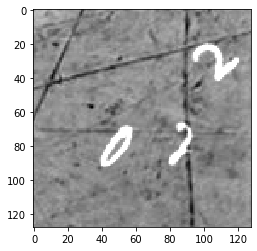

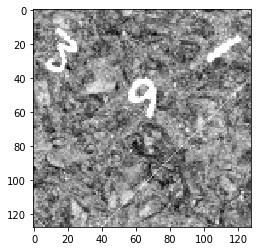

In [5]:
for i in range(4): 
    plt.figure()
    plt.imshow(train_images[i], cmap='gray') # note that the images are actually in grayscale! 
    print("Label: {}".format(train_labels[i]))

Note the shapes of our datasets, and examine the labels as well. 
These have dimensions (num_images, dim1, dim2). 

In [6]:
# Examine the shapes of our data 
print("Shape of training set: ", train_images.shape) 
print("Shape of test set: ", test_images.shape) 
print("Shape of our labels: ", train_labels.shape) 
print("Unique labels: ", LABELS)


Shape of training set:  (50000, 128, 128)
Shape of test set:  (10000, 128, 128)
Shape of our labels:  (50000,)
Unique labels:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### 2.3 Data Preprocessing 

Although some preprocessing work has already been done on these images, we still need to do a couple of things. 

1. We will reshape the data to a format tha the model can understand: (num_datapoints, dim1, dim2, channel)
2. We will further split the dataset in order to have some validation . This will also randomize the data. 
3. We will normalize the data to have values between 0 and 1. This will make a huge impact weh training. 

In [7]:
# Reshaping the images  
train_images = np.reshape( train_images, (50000, 128, 128, 1)) 
test_images = np.reshape( test_images, (10000, 128, 128, 1)) 
print("Shape of training set: ", train_images.shape) 
print("Shape of test set: ", test_images.shape) 


Shape of training set:  (50000, 128, 128, 1)
Shape of test set:  (10000, 128, 128, 1)


In [8]:
# further split into training and testing data
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(train_images, train_labels, 
                                                                    test_size=.1, # CHANGE: BEFORE 0.1
                                                                    random_state=42)

# normalize images 
X_train_new = X_train_new / 255.0 
X_test_new = X_test_new / 255.0

# convert data to tensors 
X_train_new = tf.convert_to_tensor(X_train_new, dtype=tf.float32)
X_test_new = tf.convert_to_tensor(X_test_new, dtype=tf.float32)
y_train_new = tf.keras.utils.to_categorical(y_train_new, num_classes=10)
y_test_new = tf.keras.utils.to_categorical(y_test_new, num_classes=10)

print("Shape of X_train_new {}".format(X_train_new.shape))
print("Shape of X_test_new {}".format(X_test_new.shape))


Shape of X_train_new (45000, 128, 128, 1)
Shape of X_test_new (5000, 128, 128, 1)


In [9]:
# Note that the classes have been one-ncoded to categorical
print(y_train_new[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## 3. Loading the model: DenseNet

Instead of building our own model from scratch, we will rely on state-of-the-art architectures and adpat our problem. This time, our model of choice is DenseNet, whose architecture talked about in this paper:  https://arxiv.org/abs/1608.06993


Now, we will do the following: 
1. Load the DenseNet pre-trained model. 
2. We will either train the model parameters from scratch, or we can freeze them and then apply transfer learning. This will affect the way we input the data: if the input data only contains one colour channel , i.e. grayscale, then each image will have dimensions (dim1, dim2, 1), where 1 is the grayscale colour channel. Else if we apply transfer learning(i.e., using pre-trained parameters), this number will be 3, in which case we have to modify the input images to fit them in the model. 
3. We will take the model output, add a `GlobalAveragePooling2D` layer, a `Dropout` layer to help preventing overfitting, and finally a `Dense` layer with the number of classes equal to 10 in this case, and a `softmax` activation. 
4. Then, we compile the model with an optimizer that could be either `Adam` or `SGD`. 
5. Finally, we train the model with our training and validation sets for X epochs, using small batches of size Y. 



In [0]:
# obtain respective dimensions 
img_height, img_width = train_images.shape[1], train_images.shape[2] 
num_classes = 10  

# load the base model with no pre-trained parameters
base_model = applications.densenet.DenseNet169(weights=None,  # no pre-trained parameters
                                               include_top=False,  # don't include the top classification layer 
                                           input_shape=(img_height, img_width, 1)) # input dimensions, the "1" 

**Note**: Messing up with the "Dropout" parameter affects convergence speed hugely, but also affect performance. 
Some experimentation has lead us to choose 0.5 this time. 

In [0]:
x = base_model.output 
x = GlobalAveragePooling2D()(x) 
x = Dropout(0.5)(x) # latest parameter update
predictions = Dense(num_classes, activation='softmax')(x) 
model = Model(inputs = base_model.input, outputs= predictions)

Next we compile the model with an optimizer of choice, and display the architecture. 

In [13]:
from keras.optimizers import SGD, Adam
# lr = 0.001
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   3136        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

Notice that the model initially performs extremely poorly, since no parameters have been trained yet. 

In [14]:
# Obtain the loss and accuracy before training : These metrics should be very bad

evaluation = model.evaluate(X_test_new, y_test_new)
print ("Loss = " + str(evaluation[0]))
print ("Test Accuracy = " + str(evaluation[1]))

5000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Next, we train the model for 14 epochs using the training set (45000) images and validating on 5000 images. We also use a batch-size of 32. 

In [15]:
# First training pass
history = model.fit(X_train_new, y_train_new, 
                    validation_data=(X_test_new, y_test_new), 
                    epochs = 14, batch_size = 32) # batch size8

Train on 45000 samples, validate on 5000 samples
Epoch 1/14
45000/45000 [==============================] - 206s 5ms/sample - loss: 1.6243 - accuracy: 0.4250 - val_loss: 1.9247 - val_accuracy: 0.4612
Epoch 2/14
45000/45000 [==============================] - 182s 4ms/sample - loss: 0.5631 - accuracy: 0.8220 - val_loss: 0.8028 - val_accuracy: 0.7516
Epoch 3/14
45000/45000 [==============================] - 181s 4ms/sample - loss: 0.3215 - accuracy: 0.9069 - val_loss: 1.1286 - val_accuracy: 0.6688
Epoch 4/14
45000/45000 [==============================] - 179s 4ms/sample - loss: 0.2458 - accuracy: 0.9300 - val_loss: 0.4560 - val_accuracy: 0.8840
Epoch 5/14
45000/45000 [==============================] - 177s 4ms/sample - loss: 0.2004 - accuracy: 0.9435 - val_loss: 0.2972 - val_accuracy: 0.9164
Epoch 6/14
45000/45000 [==============================] - 177s 4ms/sample - loss: 0.1635 - accuracy: 0.9534 - val_loss: 0.3940 - val_accuracy: 0.8932
Epoch 7/14
45000/45000 [===========================

In [16]:
# # Second training pass: only activate when taking a bet on the predictions
# NOTE: This might actually overfit the model! 
history2 = model.fit(X_train_new, y_train_new, 
                    validation_data=(X_test_new, y_test_new), 
                    epochs = 1, batch_size = 128)

Train on 45000 samples, validate on 5000 samples
45000/45000 [==============================] - 114s 3ms/sample - loss: 0.0224 - accuracy: 0.9935 - val_loss: 0.1160 - val_accuracy: 0.9744


In [26]:
# how about another extra epoch? 
history3 = model.fit(X_train_new, y_train_new, 
                    validation_data=(X_test_new, y_test_new), 
                    epochs = 1, batch_size = 256)

Train on 45000 samples, validate on 5000 samples
45000/45000 [==============================] - 106s 2ms/sample - loss: 0.0097 - accuracy: 0.9978 - val_loss: 0.1147 - val_accuracy: 0.9754


In [37]:
# how about another extra epoch? 
history4 = model.fit(X_train_new, y_train_new, 
                    validation_data=(X_test_new, y_test_new), 
                    epochs = 1, batch_size = 256)

Train on 45000 samples, validate on 5000 samples
45000/45000 [==============================] - 100s 2ms/sample - loss: 0.0071 - accuracy: 0.9987 - val_loss: 0.1206 - val_accuracy: 0.9760


What we did above can be potentially dangerous as the model might just overtrain and memorize the training set. However in this case, we see that the final validation accuracy also increased as well!

### 3.1 Saving and loading the model

Since training takes a lot of time, it is important to save models if we consider them important enough. We also indicate what's different in the name description. 

In [0]:
# Saving the model 
model.save('Modified_MNIST_keras_DenseNet169_14plus3epochs_dropout0.5_acc9760.h5')

## 4. Evaluating the model

In [39]:
evaluation = model.evaluate(X_test_new, y_test_new)
print ("Loss = " + str(evaluation[0]))
print ("Test Accuracy = " + str(evaluation[1]))

5000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### 4.1 Visualizing the metrics

In order to see how our model behaves over time, we visualize botht the training and validation accuracy and loss over epochs time. 

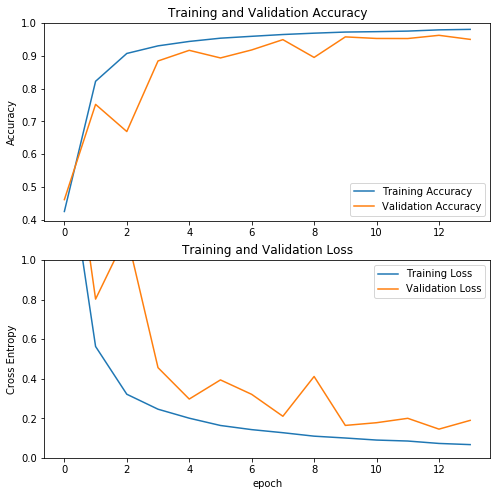

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('metrics_Modified_MNIST_keras_resnet_14plus2epochs_dropout0.6_acc9700.png')
plt.show()

## 5. Getting the Predictions

Now that we have obtained a respectable model, we are ready to output and export the predictions. 

In [0]:
# We have to perform the same kind of transformations 
real_X_test = test_images / 255.0 # set with 10000
real_X_test = np.reshape(real_X_test, (10000,128,128,1) )  #
real_X_test = tf.convert_to_tensor(real_X_test, dtype=tf.float32)
preds = model.predict(real_X_test)

Notice that the prediction values are arrays of probabilities for each class produced by the model through the softmax layer. Therefore, we will max out the argument later to produce the actual predictions.


In [41]:
preds[0]

array([4.9029171e-14, 2.0776858e-10, 7.0389622e-05, 5.1411585e-04,
       2.4921123e-03, 1.6890544e-05, 5.0501908e-06, 2.0044716e-04,
       2.4487177e-04, 9.9645621e-01], dtype=float32)

Let's first check out a couple of predictions on the validation set!


(10000, 128, 128)
Prediction:  8
Prediction:  2
Prediction:  4
Prediction:  5
Prediction:  9


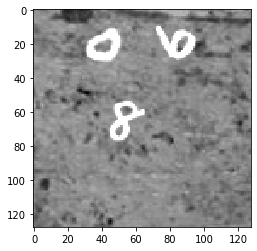

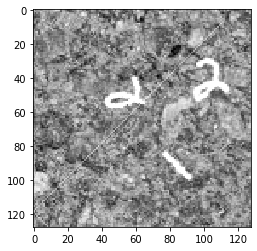

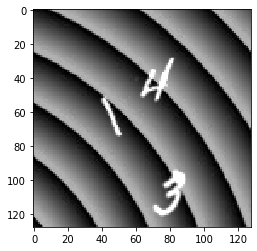

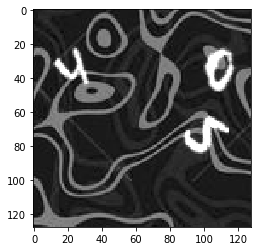

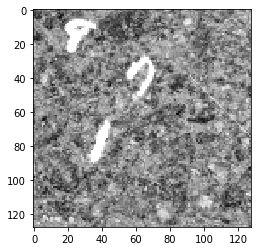

In [42]:
print(test_images.shape)
# Have to put the dimensions back as they were  
test_images = np.reshape(test_images, (10000,128,128))


for i in range(5,10): 
    plt.figure()
    plt.imshow(test_images[i], cmap='gray')
    print("Prediction: ", np.argmax(preds[i]))

It seems to be doing pretty good!

Now we will convert this to a list of predictions , and then download to submit.


In [43]:
predictions =  [np.argmax(pred) for pred in preds ] # obtain the predictions 
ids = range(0,10000) # create a list of indices
predictions = pd.DataFrame(zip(ids,predictions), columns=['Id','Label'])  # cat into a dataframe
print(predictions.head()) 

   Id  Label
0   0      9
1   1      6
2   2      4
3   3      9
4   4      5


In [0]:
from google.colab import files
predictions.to_csv('predictions_keras_DenseNet169_14plus3epochs_dropout0.5_acc9760.csv', index=False)

In [0]:
files.download('predictions_keras_DenseNet169_14plus3epochs_dropout0.5_acc9760.csv') 